<img src="https://cdn-images.threadless.com/threadless-shop/products/543/1272x920design_01.jpg" alt="This is not a pipe" style="width: 400px;"/>

# 6.1 Pipelines

_author: Mike Frantz (Santa Monica)_

---

So far, we've established a general workflow where we:


* Clean the data
  * Fill/impute/drop `NaN` values
  * One-hot encode categorical variables
  * Label-encode target if categorical
  * Check for skew / deskew


* Preprocess the data
  * Feature selection (`SelectKBest, SelectFromModel, SelectPercentile, RFE`, etc.)
  * Scaling (`StandardScaler, MinMaxScaler`)


* Modeling
  * Classification (`KNeighborsClassifier, LogisticRegression`, etc.)
  * Regression (`Lasso, Ridge, ElasticNet`, etc.)
  
For every dataset, we've done some version of all of these. Pipelines give us a convenient way to chain these tasks together. As a result, we can feed cleaned data into a pipeline and a trained model a the end!

In [1]:
import pandas as pd
import numpy as np

In [2]:
cd ..

/home/jovyan/2018-W-450-4/09-ML-pipelines


In [3]:
bike_data = pd.read_csv('data/bike_sharing.csv',index_col=0)

In [4]:
bike_data.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,1


### Clean the data

In [5]:
# Convert the datetime colum to datetime using pd.to_datetime()
bike_data['datetime'] = pd.to_datetime(bike_data['datetime'])

# Make a feature for the day of week
bike_data['dayofweek'] = bike_data['datetime'].apply(lambda x: x.dayofweek)

# Make a feature for month
bike_data['month'] = bike_data['datetime'].apply(lambda x: x.month)

# Make a feature for hour
bike_data['hour'] = bike_data['datetime'].apply(lambda x: x.hour)

In [6]:
# Drop the datetime column
bike_data.drop('datetime', axis=1, inplace=True)

#### Split up our features and target into features and target

In [7]:
features = bike_data.drop('count',axis=1)
target = bike_data['count']

In [8]:
# Get dummies of categorical columns
num_cols = ['temp','atemp','humidity','windspeed']
cat_cols = [i for i in features.columns if i not in num_cols]

In [9]:
features_dummies = pd.get_dummies(features, columns=cat_cols)

In [10]:
features_dummies.head(3)

,temp,atemp,humidity,windspeed,season_1,season_2,season_3,season_4,holiday_0,holiday_1,...,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23
0,9.84,14.395,81,0.0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,9.02,13.635,80,0.0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,9.02,13.635,80,0.0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


## `Pipeline`
---

`Pipeline` is a class in `sklearn` that allows us to chain steps together. 

We add steps to the pipeline using a list of tuples of the form `[('step name', sklearn object)...]`

Let's make a `Pipeline` that scales the data and fits a `RandomForestRegressor` model.

In [11]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import Lasso, Ridge
from sklearn.model_selection import train_test_split

In [12]:
# Train-test split your data
X_train, X_test, y_train, y_test = train_test_split(features_dummies, target, random_state = 42)

In [13]:
# Instantiate your pipeline
simple_pipe = Pipeline([('scaler',StandardScaler()), ('lasso', Lasso())])

In [14]:
# Fit the pipeline to your training features and target
simple_pipe.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('lasso', Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False))])

In [15]:
# What's your train r2 score?
simple_pipe.score(X_train, y_train)

0.63884996110229186

In [16]:
# What's your test r2 score?
simple_pipe.score(X_test, y_test)

0.62742603763215188

We now have a fit `Pipeline` object that scores just like any other model. This consists of a `StandardScaler` and a `Lasso`. What properties does this `Pipeline` have?

* `.steps` gives you a list of tuples containing the names of your steps and the fit object of the step itself.
* `.named_steps` gives you a dictionary with your pipeline objects where the keys are the names and the values are the fit sklearn object.

In [17]:
# Look at the steps
simple_pipe.steps

[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)),
 ('lasso', Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
     normalize=False, positive=False, precompute=False, random_state=None,
     selection='cyclic', tol=0.0001, warm_start=False))]

In [18]:
# Look at the named steps
simple_pipe.named_steps

{'lasso': Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
    normalize=False, positive=False, precompute=False, random_state=None,
    selection='cyclic', tol=0.0001, warm_start=False),
 'scaler': StandardScaler(copy=True, with_mean=True, with_std=True)}

We can access each step and use it if we'd like. Let's look at the mean and standard deviation of our data from the scaler object.

In [19]:
simple_pipe.steps[0][1].mean_

array([  2.02449804e+01,   2.36701605e+01,   6.18351298e+01,
         1.27913341e+01,   2.45835375e-01,   2.51224890e-01,
         2.49755022e-01,   2.53184713e-01,   9.70602646e-01,
         2.93973542e-02,   3.16756492e-01,   6.83243508e-01,
         6.62175404e-01,   2.60289074e-01,   7.74130328e-02,
         1.22488976e-04,   1.41474767e-01,   1.42822146e-01,
         1.43312102e-01,   1.43434591e-01,   1.41597256e-01,
         1.44169525e-01,   1.43189613e-01,   7.96178344e-02,
         8.30475257e-02,   8.31700147e-02,   8.14551690e-02,
         8.56197942e-02,   8.41499265e-02,   8.31700147e-02,
         8.47623714e-02,   8.18226360e-02,   8.51298383e-02,
         8.51298383e-02,   8.29250367e-02,   4.28711416e-02,
         4.10338070e-02,   4.22586967e-02,   4.00538951e-02,
         4.12787849e-02,   4.20137188e-02,   4.16462518e-02,
         4.12787849e-02,   4.21362077e-02,   4.12787849e-02,
         4.18912298e-02,   4.06663400e-02,   4.11562959e-02,
         4.04213621e-02,

In [20]:
# .std_ is deprecated, use .scale_
simple_pipe.named_steps['scaler'].scale_

array([  7.79554011e+00,   8.46820631e+00,   1.92546121e+01,
         8.21341117e+00,   4.30581401e-01,   4.33717586e-01,
         4.32871171e-01,   4.34835848e-01,   1.68917583e-01,
         1.68917583e-01,   4.65211583e-01,   4.65211583e-01,
         4.72968433e-01,   4.38792288e-01,   2.67245683e-01,
         1.10667959e-02,   3.48510628e-01,   3.49891384e-01,
         3.50390844e-01,   3.50515490e-01,   3.48636592e-01,
         3.51261545e-01,   3.50266110e-01,   2.70700637e-01,
         2.75954044e-01,   2.76139029e-01,   2.73532858e-01,
         2.79801796e-01,   2.77612529e-01,   2.76139029e-01,
         2.78527758e-01,   2.74094313e-01,   2.79074809e-01,
         2.79074809e-01,   2.75768880e-01,   2.02566549e-01,
         1.98368429e-01,   2.01178774e-01,   1.96085646e-01,
         1.98934278e-01,   2.00620453e-01,   1.99779482e-01,
         1.98934278e-01,   2.00899845e-01,   1.98934278e-01,
         2.00340597e-01,   1.97516047e-01,   1.98651593e-01,
         1.96945362e-01,

## `make_pipeline`
---

While `Pipeline` gives us the ability to explicitly name our steps, this can be cumbersome, especially when we may not care what are steps are named. If this is the case, we use `make_pipeline`.

Let's execute the same pipeline, except this time we'll use `make_pipeline`.

In [21]:
from sklearn.pipeline import make_pipeline

In [22]:
another_pipe = make_pipeline(StandardScaler(),
                             Lasso())

In [23]:
another_pipe.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('lasso', Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False))])

In [24]:
another_pipe.score(X_train, y_train)

0.63884996110229186

In [25]:
another_pipe.score(X_test, y_test)

0.62742603763215188

Even though we don't name them, `make_pipeline` still has a `.named_steps` attribute. It automatically assigns names to each step and we can access them similarly to how we did before.

In [26]:
another_pipe.named_steps

{'lasso': Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
    normalize=False, positive=False, precompute=False, random_state=None,
    selection='cyclic', tol=0.0001, warm_start=False),
 'standardscaler': StandardScaler(copy=True, with_mean=True, with_std=True)}

In [27]:
another_pipe.steps

[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)),
 ('lasso', Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
     normalize=False, positive=False, precompute=False, random_state=None,
     selection='cyclic', tol=0.0001, warm_start=False))]

### Aside: Transformation pipelines

Although it's standard to have a pipeline end in a model, it's also possible to have a pipeline just for transformers, as shown below:

In [28]:
from sklearn.feature_selection import SelectFromModel, SelectKBest, f_regression

In [29]:
transformer_pipe = make_pipeline(SelectKBest(score_func=f_regression, k=40),
                                 StandardScaler(),
                                 SelectFromModel(Lasso()))

In [30]:
X_train.shape

(8164, 59)

In [31]:
transformer_pipe.fit(X_train, y_train)

Pipeline(steps=[('selectkbest', SelectKBest(k=40, score_func=<function f_regression at 0x7f3de98d9048>)), ('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('selectfrommodel', SelectFromModel(estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False),
        prefit=False, threshold=None))])

In [48]:
features_skb_scaled_sfm = transformer_pipe.transform(X_train)

In [49]:
#X_train.shape

In [50]:
#features_skb_scaled_sfm_test = transformer_pipe.transform(X_test)

In [51]:
features_skb_scaled_sfm.shape

(8164, 36)

In [52]:
transformer_pipe.steps

[('selectkbest',
  SelectKBest(k=40, score_func=<function f_regression at 0x7f3de98d9048>)),
 ('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)),
 ('selectfrommodel',
  SelectFromModel(estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
     normalize=False, positive=False, precompute=False, random_state=None,
     selection='cyclic', tol=0.0001, warm_start=False),
          prefit=False, threshold=None))]

## Using Pipelines with `GridSearchCV`
---

So far, we've only chained transformers and models together in a `pipeline`. What if we want to use GridSearch to tune our model in the `pipeline`?

Since we have to refer to our steps by name, let's use `Pipeline` instead of `make_pipeline`. 

Let's make a pipeline with the following steps:

    ('skb', SelectKBest(score_func=f_regression, k=40)),
    ('scaler', StandardScaler()),
    ('sfm', SelectFromModel(Lasso())),
    ('regr', ElasticNet())

In [53]:
from sklearn.model_selection import GridSearchCV, ShuffleSplit
from sklearn.linear_model import ElasticNet

In [54]:
pipe_for_gs = Pipeline([
    ('skb', SelectKBest(score_func=f_regression, k=40)),
    ('scaler', StandardScaler()),
    ('sfm', SelectFromModel(Lasso())),
    ('regr', ElasticNet())
])

Next, let's make our parameter grid. When using a `Pipeline`, we need to specify which step our params are for. To do that, we use the name we gave the step (in this case `'rf'` for `RandomForestRegressor`), with a **dunder** to reference a parameter for that model. 

As an example, if we wanted to tune `ElasticNet`'s `l1_ratio` parameter, we use `regr__l1_ratio:[.1,.5,.9]`. 

Let's fill out the params below to tune `alpha` and `l1_ratio`:

In [55]:
params = {
    'regr__l1_ratio':[.1,.3,.5,.7,.9], # how much l1
    'regr__alpha':np.logspace(-3,3,7) # how much regularization
}

Now pass your pipeline into `GridSearchCV` with your parameters, using `ShuffleSplit`

In [56]:
gspipe = GridSearchCV(pipe_for_gs,
                      param_grid=params,
                      n_jobs=-1,
                      cv=ShuffleSplit(n_splits=5, random_state=42))

In [57]:
gspipe.fit(X_train, y_train.ravel())

GridSearchCV(cv=ShuffleSplit(n_splits=5, random_state=42, test_size=0.1, train_size=None),
       error_score='raise',
       estimator=Pipeline(steps=[('skb', SelectKBest(k=40, score_func=<function f_regression at 0x7f3de98d9048>)), ('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('sfm', SelectFromModel(estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precom...alse, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False))]),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'regr__l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9], 'regr__alpha': array([  1.00000e-03,   1.00000e-02,   1.00000e-01,   1.00000e+00,
         1.00000e+01,   1.00000e+02,   1.00000e+03])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [58]:
gspipe.best_score_

0.64417030407767828

To get the `.steps` or `.named_steps`, we need to access `GridSearchCV`'s `.best_estimator_` parameter, which contains our `Pipeline`. How do we access our model? Our scaler?

In [59]:
gspipe.best_estimator_.named_steps

{'regr': ElasticNet(alpha=0.001, copy_X=True, fit_intercept=True, l1_ratio=0.9,
       max_iter=1000, normalize=False, positive=False, precompute=False,
       random_state=None, selection='cyclic', tol=0.0001, warm_start=False),
 'scaler': StandardScaler(copy=True, with_mean=True, with_std=True),
 'sfm': SelectFromModel(estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
    normalize=False, positive=False, precompute=False, random_state=None,
    selection='cyclic', tol=0.0001, warm_start=False),
         prefit=False, threshold=None),
 'skb': SelectKBest(k=40, score_func=<function f_regression at 0x7f3de98d9048>)}

In [60]:
gspipe.best_estimator_.named_steps['regr']

ElasticNet(alpha=0.001, copy_X=True, fit_intercept=True, l1_ratio=0.9,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [61]:
gspipe.best_estimator_.named_steps['sfm']

SelectFromModel(estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False),
        prefit=False, threshold=None)

## Grid-searching preprocessing steps *and* model parameters
---

Let's augment our GridSearch from before. Except this time, let's GridSearch our preprocessing steps too to find an optimal pipeline. 

Before we code it up, look at this handy diagram from `mglearn`. Now finally, we've got proper processing where we're cross-validating not only our models, but our preprocessing steps. **From now on, this is how you should do ALL your modeling!**

In [62]:
!pip install --quiet mglearn

In [64]:
import mglearn
mglearn.plots.plot_improper_processing()

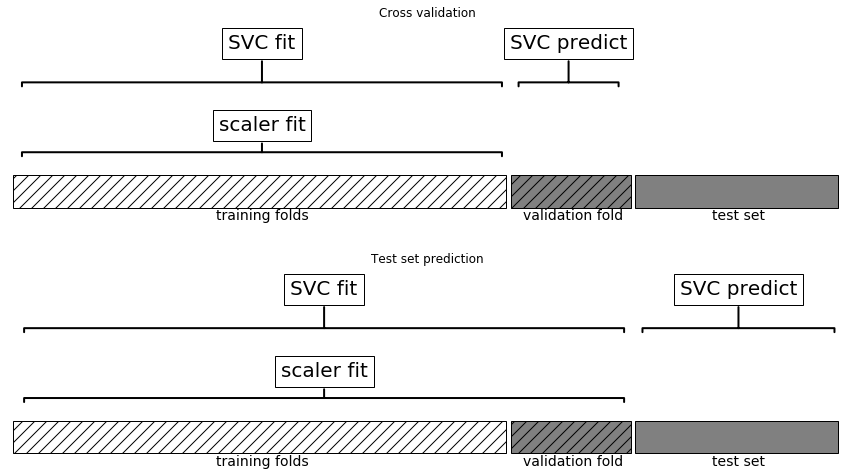

In [65]:
import mglearn
%matplotlib inline
mglearn.plots.plot_proper_processing()

In [66]:
pipe_for_gs = Pipeline([
    ('skb', SelectKBest(score_func=f_regression, k=40)),
    ('scaler', StandardScaler()),
    ('sfm', SelectFromModel(Lasso())),
    ('regr', ElasticNet())
])

In [67]:
params = {
    'regr__l1_ratio':[.1,.3,.5,.7,.9],
    'regr__alpha':np.logspace(-3,3,7),
    'skb__k':[50, 40],
    'sfm__estimator':[Lasso(), Ridge()]
}

In [68]:
gspipe = GridSearchCV(pipe_for_gs,
                      param_grid=params,
                      n_jobs=-1,
                      cv=ShuffleSplit(n_splits=5, random_state=42)
                     )

This will take a while, and you may see some errors...

In [69]:
gspipe.fit(X_train, y_train.ravel())

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of

GridSearchCV(cv=ShuffleSplit(n_splits=5, random_state=42, test_size=0.1, train_size=None),
       error_score='raise',
       estimator=Pipeline(steps=[('skb', SelectKBest(k=40, score_func=<function f_regression at 0x7f3de98d9048>)), ('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('sfm', SelectFromModel(estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precom...alse, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False))]),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'regr__l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9], 'regr__alpha': array([  1.00000e-03,   1.00000e-02,   1.00000e-01,   1.00000e+00,
         1.00000e+01,   1.00000e+02,   1.00000e+03]), 'skb__k': [50, 40], 'sfm__estimator': [Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   ...it_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.00

In [70]:
gspipe_results = pd.DataFrame(gspipe.cv_results_)

gspipe_results.sort_values('rank_test_score', ascending=True).T

,16,12,8,4,0,36,32,28,24,20,...,123,122,138,120,119,118,117,116,126,139
mean_fit_time,0.299302,0.303187,0.336216,0.295291,0.335804,0.267271,0.256173,0.243574,0.223235,0.226629,...,0.0358196,0.0413394,0.0396444,0.150191,0.0324168,0.0388289,0.139857,0.150099,0.0414382,0.0353362
mean_score_time,0.00470228,0.00471344,0.00397501,0.00469613,0.00403438,0.00465426,0.00505619,0.00493112,0.00708108,0.00431542,...,0.00390639,0.00431399,0.00409684,0.00532107,0.00403576,0.00431042,0.0052577,0.00531087,0.00441694,0.0039887
mean_test_score,0.647937,0.647936,0.647934,0.647933,0.647932,0.647931,0.647907,0.64787,0.647824,0.647771,...,-0.00105024,-0.00105024,-0.00105024,-0.00105024,-0.00105024,-0.00105024,-0.00105024,-0.00105024,-0.00105024,-0.00105024
mean_train_score,0.638592,0.638592,0.638592,0.638591,0.638591,0.63859,0.638577,0.638557,0.638532,0.638502,...,0,0,0,0,0,0,0,0,0,0
param_regr__alpha,0.001,0.001,0.001,0.001,0.001,0.01,0.01,0.01,0.01,0.01,...,1000,1000,1000,1000,100,100,100,100,1000,1000
param_regr__l1_ratio,0.9,0.7,0.5,0.3,0.1,0.9,0.7,0.5,0.3,0.1,...,0.1,0.1,0.9,0.1,0.9,0.9,0.9,0.9,0.3,0.9
param_sfm__estimator,"Lasso(alpha=1.0, copy_X=True, fit_intercept=Tr...","Lasso(alpha=1.0, copy_X=True, fit_intercept=Tr...","Lasso(alpha=1.0, copy_X=True, fit_intercept=Tr...","Lasso(alpha=1.0, copy_X=True, fit_intercept=Tr...","Lasso(alpha=1.0, copy_X=True, fit_intercept=Tr...","Lasso(alpha=1.0, copy_X=True, fit_intercept=Tr...","Lasso(alpha=1.0, copy_X=True, fit_intercept=Tr...","Lasso(alpha=1.0, copy_X=True, fit_intercept=Tr...","Lasso(alpha=1.0, copy_X=True, fit_intercept=Tr...","Lasso(alpha=1.0, copy_X=True, fit_intercept=Tr...",...,"Ridge(alpha=1.0, copy_X=True, fit_intercept=Tr...","Ridge(alpha=1.0, copy_X=True, fit_intercept=Tr...","Ridge(alpha=1.0, copy_X=True, fit_intercept=Tr...","Lasso(alpha=1.0, copy_X=True, fit_intercept=Tr...","Ridge(alpha=1.0, copy_X=True, fit_intercept=Tr...","Ridge(alpha=1.0, copy_X=True, fit_intercept=Tr...","Lasso(alpha=1.0, copy_X=True, fit_intercept=Tr...","Lasso(alpha=1.0, copy_X=True, fit_intercept=Tr...","Ridge(alpha=1.0, copy_X=True, fit_intercept=Tr...","Ridge(alpha=1.0, copy_X=True, fit_intercept=Tr..."
param_skb__k,50,50,50,50,50,50,50,50,50,50,...,40,50,50,50,40,50,40,50,50,40
params,"{'regr__alpha': 0.001, 'regr__l1_ratio': 0.9, ...","{'regr__alpha': 0.001, 'regr__l1_ratio': 0.7, ...","{'regr__alpha': 0.001, 'regr__l1_ratio': 0.5, ...","{'regr__alpha': 0.001, 'regr__l1_ratio': 0.3, ...","{'regr__alpha': 0.001, 'regr__l1_ratio': 0.1, ...","{'regr__alpha': 0.01, 'regr__l1_ratio': 0.9, '...","{'regr__alpha': 0.01, 'regr__l1_ratio': 0.7, '...","{'regr__alpha': 0.01, 'regr__l1_ratio': 0.5, '...","{'regr__alpha': 0.01, 'regr__l1_ratio': 0.3, '...","{'regr__alpha': 0.01, 'regr__l1_ratio': 0.1, '...",...,"{'regr__alpha': 1000.0, 'regr__l1_ratio': 0.1,...","{'regr__alpha': 1000.0, 'regr__l1_ratio': 0.1,...","{'regr__alpha': 1000.0, 'regr__l1_ratio': 0.9,...","{'regr__alpha': 1000.0, 'regr__l1_ratio': 0.1,...","{'regr__alpha': 100.0, 'regr__l1_ratio': 0.9, ...","{'regr__alpha': 100.0, 'regr__l1_ratio': 0.9, ...","{'regr__alpha': 100.0, 'regr__l1_ratio': 0.9, ...","{'regr__alpha': 100.0, 'regr__l1_ratio': 0.9, ...","{'regr__alpha': 1000.0, 'regr__l1_ratio': 0.3,...","{'regr__alpha': 1000.0, 'regr__l1_ratio': 0.9,..."
rank_test_score,1,2,3,4,5,6,7,8,9,10,...,117,117,117,117,117,117,117,117,117,117


##  NOTE:

You can also use user-defined classes to build preprocessing into Pipelines, as long as they have a `.fit` and a `.transform` method. 